# Text Classification w/o Using Text itself (with CatBoostClassifier)
## In this notebook I'll use 'Real or Not? NLP with Disaster Tweets' Dataset to train model for real/notreal disaster classification. 

In [1]:
# Importing all needed libraries 

!python -m spacy download en_core_web_md

import re
import numpy as np
import pandas as pd
import spacy
import en_core_web_md
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 96.4 MB 56.8 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=1b5b13b4f0d126fc4711d0c16333e1448a759833cab6fbd2354ec07e4f8b65db
  Stored in directory: /tmp/pip-ephem-wheel-cache-j55g_bz2/wheels/91/dd/30/01b00272fbb8fbcdafcac24f3c7d362ce2d8ba296071b41d99
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
# Here are the functions I use for preprocessing tweets and extracting features from texts

def prepros(tweet):
    """
    Tokenize input text, removes stop words and punctuations.
    
    Returns:
    -List of tokens
    """
    tweet = re.sub(r'[^0-9a-zA-Z ]', '', tweet).lower()
    doc = nlp(tweet)
    words = [token.lemma_ for token in doc if not (token.is_stop) and not (token.is_punct)]
    return words

def words_counter(text):
    n_words = len([word for word in text if not len(word) == 0])
    return n_words

def tag_counter(tweet):
    return len([x for x in tweet if '@' in x])

def average_len(tweet):
    lengths = [len(x) for x in tweet]
    return sum(lengths)/len(tweet)

def hashtag_counter(tweet):
    return len([x for x in tweet if '#' in x])

def ents_counter(doc):
    return len(doc.ents)

def punct_counter(doc):
    return len([token for token in doc if token.is_punct])

def link_detector(tweet):
    lst = [x for x in tweet if 'http' in x]
    if len(lst) == 0:
        return np.nan
    else:
        return lst[0]
    
def verb_counter(tweet):
    lst = [x for x in tweet if x.pos_ == 'VERB']
    return len(lst)

def noun_counter(tweet):
    lst = [x for x in tweet if x.pos_ == 'NOUN']
    return len(lst)

In [3]:
test_data = pd.read_csv("../input/nlp-getting-started/test.csv")
train_data = pd.read_csv("../input/nlp-getting-started/train.csv")

# Load language data for Spacy text processing
nlp = en_core_web_md.load()

In [4]:
# Transforming text to tokenized text and Doc type for further manipulations
train_data['tok_text'] = train_data.text.apply(lambda x: x.split(' '))
train_data['doc'] = train_data.text.apply(lambda x: nlp(x))

# applying functions to train data
train_data['n_words'] = train_data.tok_text.apply(words_counter)
train_data['n_tags'] = train_data.tok_text.apply(tag_counter)
train_data['n_hashtags'] = train_data.tok_text.apply(hashtag_counter)
train_data['avg_len_word'] = train_data.tok_text.apply(average_len)
train_data['n_ents'] = train_data.doc.apply(ents_counter)
train_data['links'] = train_data.tok_text.apply(link_detector)
train_data['verbs'] = train_data.doc.apply(verb_counter)
train_data['nouns'] = train_data.doc.apply(noun_counter)

train_data.fillna(-999, inplace=True)  # CatBoost handles outliers, so we don't need to worry about NaN values

features_to_drop = ['id', 'text', 'tok_text', 'doc']

X = train_data.drop(features_to_drop + ['target'], axis=1)
y = train_data.target

# The same manipulations with test data
test_data['tok_text'] = train_data.text.apply(lambda x: x.split(' '))
test_data['doc'] = train_data.text.apply(lambda x: nlp(x))

test_data['n_words'] = test_data.tok_text.apply(words_counter)
test_data['n_tags'] = test_data.tok_text.apply(tag_counter)
test_data['n_hashtags'] = test_data.tok_text.apply(hashtag_counter)
test_data['avg_len_word'] = test_data.tok_text.apply(average_len)
test_data['n_ents'] = test_data.doc.apply(ents_counter)
test_data['links'] = test_data.tok_text.apply(link_detector)
test_data['verbs'] = test_data.doc.apply(verb_counter)
test_data['nouns'] = test_data.doc.apply(noun_counter)

test_data.fillna(-999, inplace=True)

X_test = test_data.drop(features_to_drop, axis=1)

display(train_data)
display(test_data)

id keyword location  \
0         1    -999     -999   
1         4    -999     -999   
2         5    -999     -999   
3         6    -999     -999   
4         7    -999     -999   
...     ...     ...      ...   
7608  10869    -999     -999   
7609  10870    -999     -999   
7610  10871    -999     -999   
7611  10872    -999     -999   
7612  10873    -999     -999   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  Police investigating after an e-bike collided ...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

                                               tok_text  \
0     [Our, Deeds, are, the, Reason, of, this, #eart...   
1        [Forest, fire, near, La, Ronge, Sask., Canada]   
2     [All, residents, asked, to, 'shelter, in, plac...   
3     [13,000, people, receive, #wildfires, evacuati...   
4     [Just, got, sent, this, photo, from, Ruby, #Al...   
...                                                 ...   
7608  [Two, giant, cranes, holding, a, bridge, colla...   
7609  [@aria_ahrary, @TheTawniest, The, out, of, con...   
7610  [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...   
7611  [Police, investigating, after, an, e-bike, col...   
7612  [The, Latest:, More, Homes, Razed, by, Norther...   

                                                    doc  n_words  n_tags  \
0     (Our, Deeds, are, the, Reason, of, this, #, ea...       13       0   
1      (Forest, fire, near, La, Ronge, Sask, ., Canada)        7       0   
2     (All, residents, asked, to, ', shelter, in, pl...       22       0   
3     (13,000, people, receive, #, wildfires, evacua...        8       0   
4     (Just, got, sent, this, photo, from, Ruby, #, ...       16       0   
...                                                 ...      ...     ...   
7608  (Two, giant, cranes, holding, a, bridge, colla...       11       0   
7609  (@aria_ahrary, @TheTawniest, The, out, of, con...       20       2   
7610  (M1.94, [, 01:04, UTC]?5, km, S, of, Volcano, ...        8       0   
7611  (Police, investigating, after, an, e, -, bike,...       19       0   
7612  (The, Latest, :, More, Homes, Razed, by, North...       13       0   

      n_hashtags  avg_len_word  n_ents                   links  verbs  nouns  
0              1      4.384615       1                    -999      2      3  
1              0      4.571429       2                    -999      0      2  
2              0      5.090909       0                    -999      4      7  
3              1      6.333333       3                    -999      1      4  
4              2      4.235294       1                    -999      3      5  
...          ...           ...     ...                     ...    ...    ...  
7608           0      6.636364       1  http://t.co/STfMbbZFB5      1      4  
7609           0      5.300000       2                    -999      0      4  
7610           0      7.250000       1  http://t.co/zDtoyd8EbJ      0      0  
7611           0      6.263158       1                    -999      3      8  
7612           0      6.307692       0  http://t.co/YmY4rSkQ3d      1      1  

[7613 rows x 15 columns]

id keyword location  \
0         0    -999     -999   
1         2    -999     -999   
2         3    -999     -999   
3         9    -999     -999   
4        11    -999     -999   
...     ...     ...      ...   
3258  10861    -999     -999   
3259  10865    -999     -999   
3260  10868    -999     -999   
3261  10874    -999     -999   
3262  10875    -999     -999   

                                                   text  \
0                    Just happened a terrible car crash   
1     Heard about #earthquake is different cities, s...   
2     there is a forest fire at spot pond, geese are...   
3              Apocalypse lighting. #Spokane #wildfires   
4         Typhoon Soudelor kills 28 in China and Taiwan   
...                                                 ...   
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...   
3259  Storm in RI worse than last hurricane. My city...   
3260  Green Line derailment in Chicago http://t.co/U...   
3261  MEG issues Hazardous Weather Outlook (HWO) htt...   
3262  #CityofCalgary has activated its Municipal Eme...   

                                               tok_text  \
0     [Our, Deeds, are, the, Reason, of, this, #eart...   
1        [Forest, fire, near, La, Ronge, Sask., Canada]   
2     [All, residents, asked, to, 'shelter, in, plac...   
3     [13,000, people, receive, #wildfires, evacuati...   
4     [Just, got, sent, this, photo, from, Ruby, #Al...   
...                                                 ...   
3258  [Do, you, feel, engulfed, with, low, self-imag...   
3259  [Man, is, equally, incapable, of, seeing, the,...   
3260  [Fully, Engulfed, Garage, Fire:, Propane, Tank...   
3261  [He, came, to, a, land, which, was, engulfed, ...   
3262  [@suelinflower, there, is, no, words, to, desc...   

                                                    doc  n_words  n_tags  \
0     (Our, Deeds, are, the, Reason, of, this, #, ea...       13       0   
1      (Forest, fire, near, La, Ronge, Sask, ., Canada)        7       0   
2     (All, residents, asked, to, ', shelter, in, pl...       22       0   
3     (13,000, people, receive, #, wildfires, evacua...        8       0   
4     (Just, got, sent, this, photo, from, Ruby, #, ...       16       0   
...                                                 ...      ...     ...   
3258  (Do, you, feel, engulfed, with, low, self, -, ...       12       0   
3259  (Man, is, equally, incapable, of, seeing, the,...       23       0   
3260  (Fully, Engulfed, Garage, Fire, :, Propane, Ta...        9       0   
3261  (He, came, to, a, land, which, was, engulfed, ...       23       0   
3262  (@suelinflower, there, is, no, words, to, desc...       22       1   

      n_hashtags  avg_len_word  n_ents                   links  verbs  nouns  
0              1      4.384615       1                    -999      2      3  
1              0      4.571429       2                    -999      0      2  
2              0      5.090909       0                    -999      4      7  
3              1      6.333333       3                    -999      1      4  
4              2      4.235294       1                    -999      3      5  
...          ...           ...     ...                     ...    ...    ...  
3258           0      7.583333       0  http://t.co/YzDmouXQBO      3      3  
3259           0      4.695652       1                    -999      3      3  
3260           0      6.222222       1                    -999      0      0  
3261           2      4.391304       2                    -999      3      4  
3262           0      5.272727       2                    -999      4      2  

[3263 rows x 14 columns]

In [5]:
# Splits training data into training set and validation set
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

# Creates Pool class for convinient usage in CatBoost Classifier
train_Pool = Pool(X_train, y_train, cat_features=[0, 1, 7])

In [6]:
# Training our Classifier
model = CatBoostClassifier(verbose=False, 
                           custom_metric='F1')
                           
model.fit(train_Pool)

In [7]:
y_pred_eval = model.predict(X_eval)

F1_eval = metrics.f1_score(y_eval, y_pred_eval)
print(F1_eval)

0.7198723064644853


So, I've got ~0.72, the score is pretty good for model without tuning. If you want to improve the result, you can tune the Classifier. Let's have look what gave us such good score

Text(0.5, 1.0, 'Feature Importance')

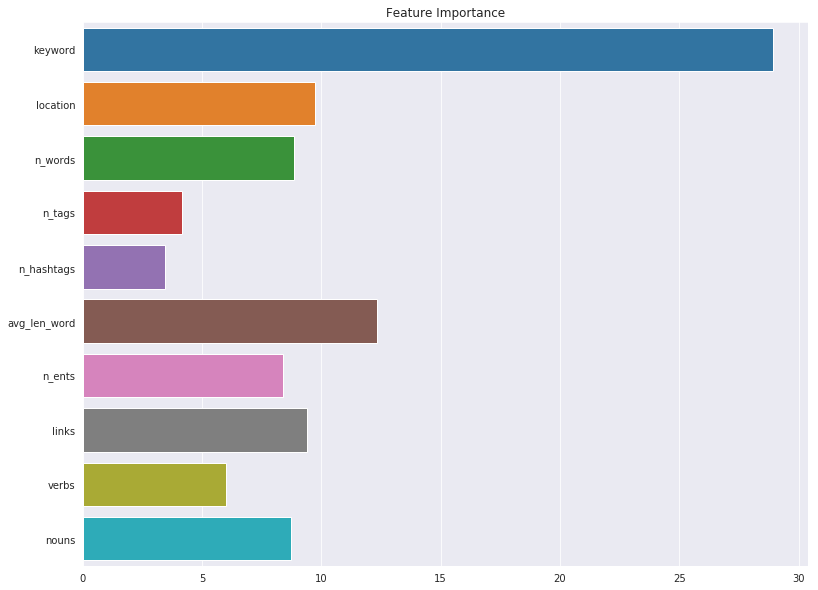

In [8]:
feat_importance = model.get_feature_importance(train_Pool)

plt.figure(figsize=(13, 10))
sns.set_style('darkgrid')
sns.barplot(x=feat_importance, y=X_train.columns).set_title('Feature Importance')

As you can see, the 'keyword' feature impacts the result very much.

Let's check how good our model with only this feature.

In [9]:
model_key = CatBoostClassifier(verbose=False,
                             custom_metric='F1')

X_train_key = pd.DataFrame(X_train.keyword) # I have 'KeyError: 0' using Series, so let it be a DF

model_key.fit(Pool(X_train_key, y_train, cat_features=[0]))

print(metrics.f1_score(y_eval, model_key.predict(X_eval.keyword)))

0.6650755767700874


With only 'keyword' feature I have ~0.66 F1 score, so it was interesting thing about this dataset.